In [1]:
#!/usr/bin/env python
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [3]:
import warnings
warnings.filterwarnings("ignore")


--- DIPPED PRODUCTS PLC - revenue ---
Train period: 2021-03-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-09-30 00:00:00 to 2024-12-31 00:00:00
auto_arima failed with error: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Retrying with forced seasonal differencing D=0
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=528.248, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=521.885, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=525.347, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=524.044, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=533.607, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=523.302, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=521.465, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=523.430, Time=0.06 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=523.449, Time=0.04 sec
 ARIMA(0,0,

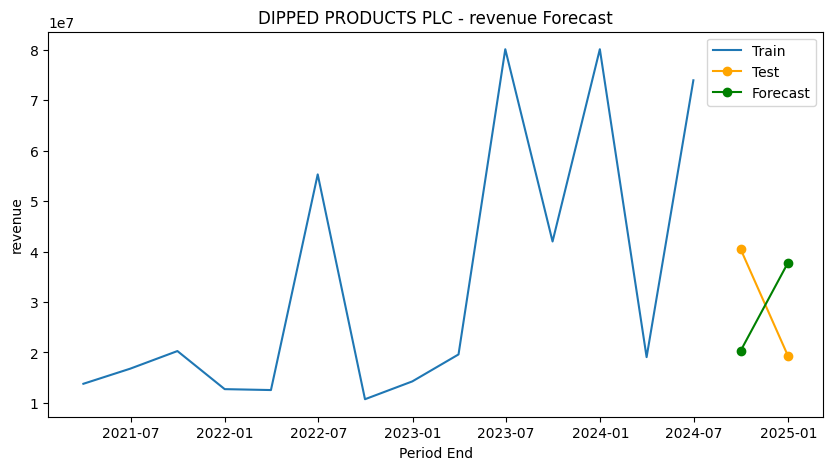

Final Metrics: {'MAE': 19277212.47800239, 'RMSE': np.float64(19296170.69244111)}


In [4]:
def train_forecast_series(series, metric_name, company_name, train_periods=14, seasonal_period=4):
    series = series.sort_index()
    train = series.iloc[:train_periods]
    test = series.iloc[train_periods:train_periods+2]
    
    print(f"\n--- {company_name} - {metric_name} ---")
    print("Train period:", train.index.min(), "to", train.index.max())
    print("Test period:", test.index.min(), "to", test.index.max())
    
    try:
        stepwise_fit = auto_arima(train,
                                  seasonal=True,
                                  m=seasonal_period,
                                  trace=True,
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=True)
    except ValueError as e:
        print("auto_arima failed with error:", e)
        print("Retrying with forced seasonal differencing D=0")
        stepwise_fit = auto_arima(train,
                                  seasonal=True,
                                  m=seasonal_period,
                                  D=0,
                                  trace=True,
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=True)
    print(stepwise_fit.summary())
    
    order = stepwise_fit.order
    seasonal_order = stepwise_fit.seasonal_order
    
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    print(model_fit.summary())
    
    n_test = len(test)
    forecast = model_fit.forecast(steps=n_test)
    
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    metrics = {"MAE": mae, "RMSE": rmse}
    print(f"Evaluation for {company_name} - {metric_name}: MAE={mae:.2f}, RMSE={rmse:.2f}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', marker='o', color='orange')
    plt.plot(test.index, forecast, label='Forecast', marker='o', color='green')
    plt.title(f"{company_name} - {metric_name} Forecast")
    plt.xlabel("Period End")
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()
    
    return model_fit, forecast, metrics

def main():
    data_path = os.path.join("..", "outputs", "processed_dataset.csv")
    df = pd.read_csv(data_path, parse_dates=["period_end"])
    
    # Filter for DIPPED PRODUCTS PLC and extract revenue series.
    df_dipd = df[df['company_name'] == "DIPPED PRODUCTS PLC"].copy()
    df_dipd.sort_values("period_end", inplace=True)
    ts_revenue = df_dipd.set_index("period_end")["revenue"]
    
    model_fit, forecast, metrics = train_forecast_series(ts_revenue, "revenue", "DIPPED PRODUCTS PLC")
    print("Final Metrics:", metrics)

if __name__ == "__main__":
    main()
